### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

# os.chdir('/home/mattho/git/ltu-cmass/matts_tests')


In [2]:
wdir = '/automnt/data80/mattho/cmass-ili'
wdir = '/anvil/scratch/x-mho1/cmass-ili'

## Halo catalog inference

### Load training and test data

In [3]:
def get_cosmo(source_path):
    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    return np.array(cfg.nbody.cosmo)

def get_halo_Pk(source_path):
    diag_file = join(source_path, 'diag', 'halos.h5')
    if not os.path.exists(diag_file):
        return None, None, None
    with h5py.File(diag_file, 'r') as f:
        a = list(f.keys())[-1]
        k = f[a]['Pk_k'][:]
        Pk = f[a]['Pk'][:]
    cosmo = get_cosmo(source_path)
    return k, Pk, cosmo

In [4]:
# Training suite
suite = 'quijotelike'
sim = 'fastpm'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktrain, Pktrain, cosmotrain = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktrain.append(k)
    Pktrain.append(Pk)
    cosmotrain.append(cosmo)

ktrain, Pktrain, cosmotrain = map(lambda x: [i for i in x if i is not None], [ktrain, Pktrain, cosmotrain])
ktrain, Pktrain, cosmotrain = map(np.stack, [ktrain, Pktrain, cosmotrain])
print(ktrain.shape, Pktrain.shape, cosmotrain.shape)

100%|██████████| 2000/2000 [00:21<00:00, 94.72it/s] 


(2000, 110) (2000, 110, 3) (2000, 5)


In [5]:
# Test suite
suite = 'quijote'
sim = 'nbody'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktest, Pktest, cosmotest = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktest.append(k)
    Pktest.append(Pk)
    cosmotest.append(cosmo)

ktest, Pktest, cosmotest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest])
ktest, Pktest, cosmotest = map(np.stack, [ktest, Pktest, cosmotest])
print(ktest.shape, Pktest.shape, cosmotest.shape)

100%|██████████| 2000/2000 [00:18<00:00, 109.68it/s]


(2000, 110) (2000, 110, 3) (2000, 5)


/tmp/ipykernel_3702216/605162171.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


[Text(0.5, 0, 'k'), Text(0, 0.5, 'P(k)')]

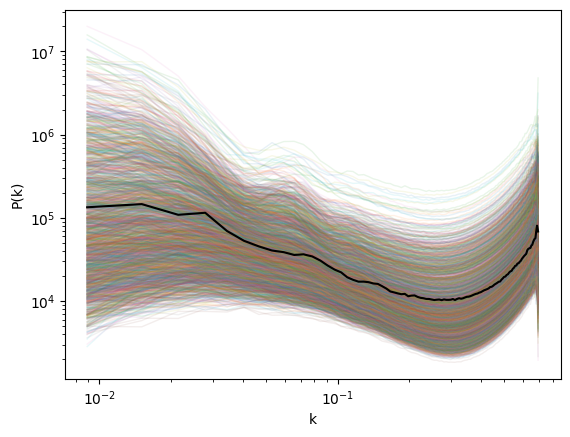

In [6]:
l = 10

f, ax = plt.subplots()
cmap = mpl.cm.get_cmap('viridis')
Om = cosmotrain[:,0]
for k, Pk, cosmo in zip(ktrain, Pktrain[...,0], Om):
    omnorm = (Om-Om.min())/(Om.max()-Om.min())
    ax.loglog(k, Pk, lw=1, alpha=0.1)
ax.loglog(ktest[l], Pktest[l,...,0], 'k')
ax.set(xlabel='k', ylabel='P(k)')

### Train

In [7]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    embedding = FCN(n_hidden=[64, 32, 16], act_fn='ReLU')

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(
            model='maf', hidden_features=50, num_transforms=5,
            embedding_net=embedding),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 1e-5
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

/anvil/projects/x-phy240043/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# train at different resolutions
kmaxs = [0.1, 0.2]#, 0.4, 0.6]

# impute with mean
def impute(arr):
    # Compute the mean of each row, ignoring nan values
    col_mean = np.nanmean(arr, axis=1)
    
    # Find the indices where values are nan
    inds = np.where(np.isnan(arr))
    
    # Replace nan values with the mean of the respective column
    arr[inds] = np.take(col_mean, inds[0])
    return arr

In [9]:
posteriors, summaries = {}, {}
for kmax in kmaxs:
    print(f'Training for kmax={kmax}')

    # focus on the monopole
    x = Pktrain[:, :, 0]

    # cut on k
    mask = ktrain[0] < kmax
    x = x[:, mask]
    theta = cosmotrain

    # log
    x = np.log10(x)

    # # impute
    # x = impute(x)

    # train
    _p, _s = run_inference(x, theta)
    posteriors[kmax] = _p
    summaries[kmax] = _s


INFO:root:MODEL INFERENCE CLASS: NPE


Training for kmax=0.1


INFO:root:Training model 1 / 1.
0 epochs [04:12, ? epochs/s]


KeyboardInterrupt: 

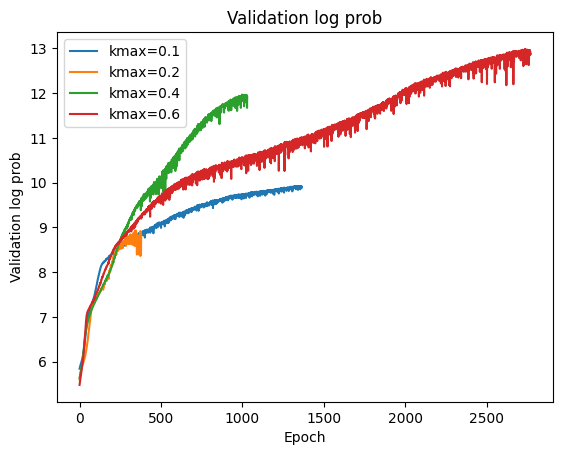

In [18]:
# plot loss functions
f, ax = plt.subplots()
for kmax in kmaxs:
    ax.plot(summaries[kmax][0]['validation_log_probs'], label=f'kmax={kmax}')
ax.set(xlabel='Epoch', ylabel='Validation log prob', title='Validation log prob')
ax.legend()

### Plot

In [ ]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = None
for i, kmax in enumerate(kmaxs):
    print(kmax)
    xobs = Pktest[:, :, 0]
    mask = ktest[0] < kmax
    xobs = xobs[:, mask]
    xobs = np.log10(xobs)
    xobs = impute(xobs)
    _p = posteriors[kmax]
    fig = metric(
        posterior=_p,
        x_obs = xobs[10], theta_fid = cosmotest[10],
        grid=fig,
        name=f'kmax={kmax}'
    )

In [38]:
kmax = 0.2
_p = posteriors[kmax]
xobs = Pktest[:, :, 0]
mask = ktest[0] < kmax
xobs = xobs[:, mask]
xobs = np.log10(xobs)
xobs = impute(xobs)
i = 10
xobs[i], cosmotest[i]

(array([5.46294829, 5.5860705 , 5.41855217, 5.34866254, 5.15058453,
        5.07696243, 4.99867311, 4.94842538, 4.93540437, 4.92799706,
        4.8653845 , 4.77764531, 4.72798334, 4.67652098, 4.61761071,
        4.62677668, 4.58861439, 4.57746594, 4.58157749, 4.55155668,
        4.53498866, 4.5033113 , 4.47192938, 4.46100612, 4.43711576,
        4.43420067, 4.43158977, 4.43044334, 4.4202343 , 4.4003263 ,
        4.39349984]),
 array([0.1821 , 0.04809, 0.5865 , 0.9565 , 0.8101 ]))

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1429it [00:00, 7247.78it/s]                         


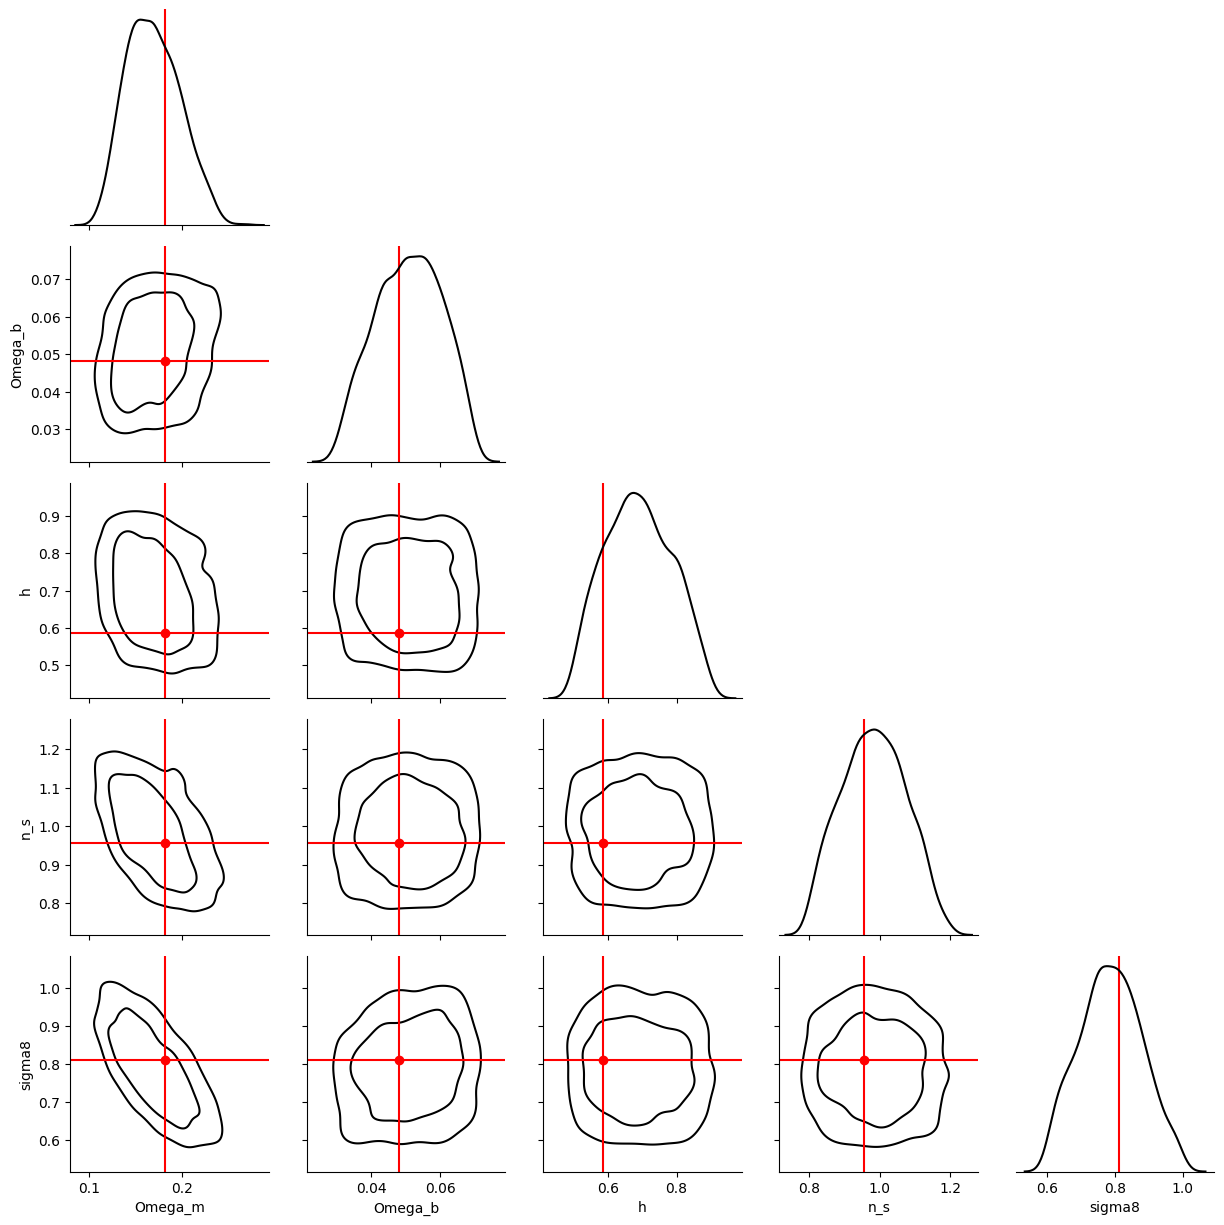

In [39]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=_p,
    x_obs = xobs[10], theta_fid = cosmotest[10],
    grid=None,
    name=f'kmax={kmax}'
)

  2%|▏         | 38/2000 [00:01<01:34, 20.87it/s]

 47%|████▋     | 947/2000 [00:39<00:48, 21.93it/s]/home/mattho/git/ltu-ili/ili/utils/ndes_pt.py:174: UserWarning: Direct sampling took too long. The posterior is poorly constrained within the prior support. Consider using emcee sampling or using a larger prior support. Returning prior samples.
  warnings.warn(
100%|██████████| 2000/2000 [01:22<00:00, 24.26it/s]
INFO:root:Mean logprob: -1.2334e+01Median logprob: 6.2751e+00
100%|██████████| 100/100 [00:13<00:00,  7.45it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


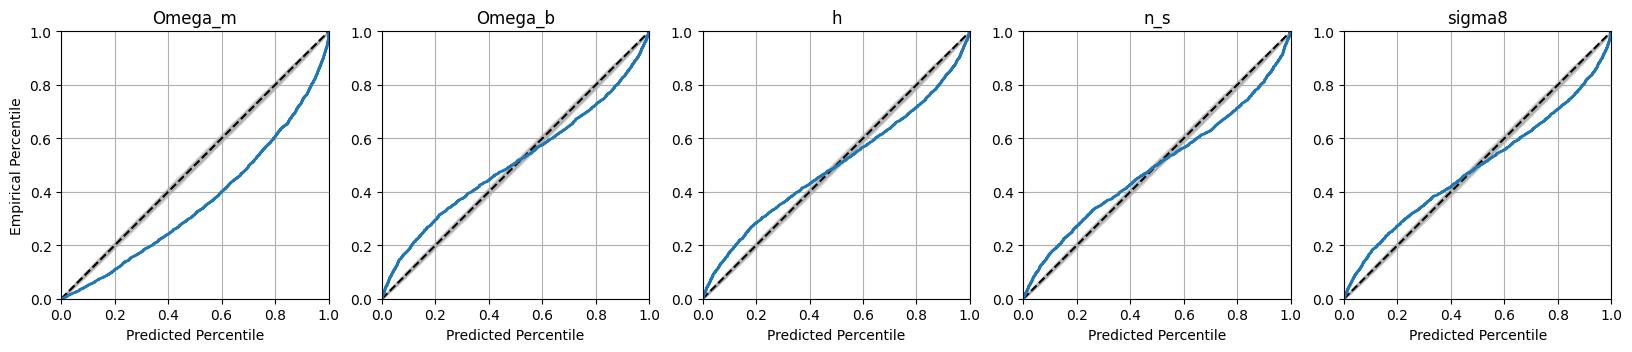

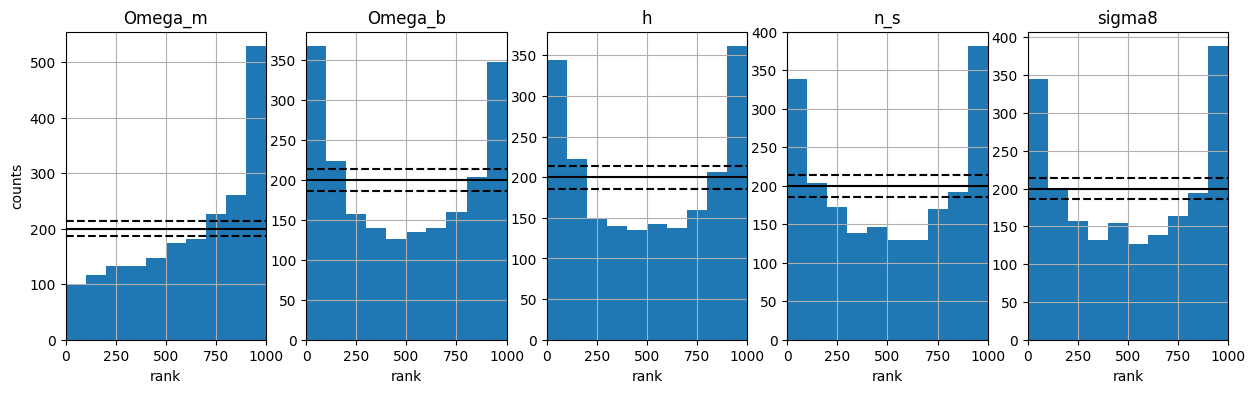

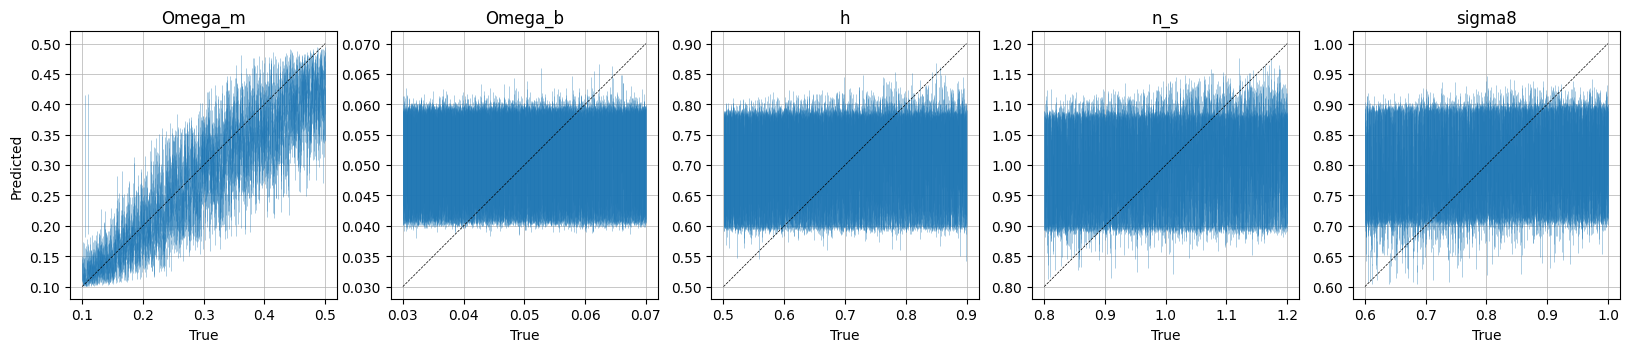

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


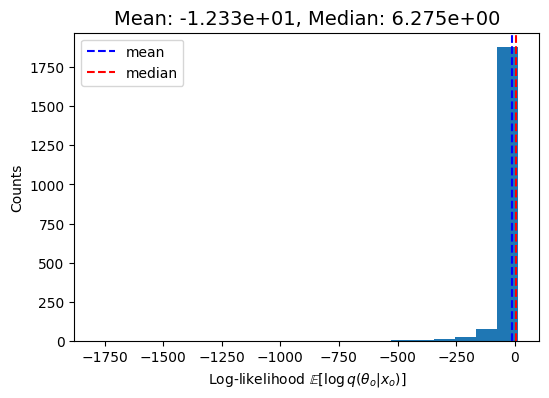

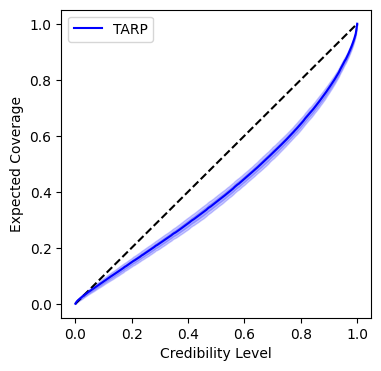

In [40]:
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)
metric(posterior=_p, x=xobs, theta=cosmotest);

## HOD constraints

In [37]:
from cmass.bias.apply_hod import get_hod_params

def get_cosmo(source_path):
    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    return np.array(cfg.nbody.cosmo)

def get_gal_Pk(source_path, hod_seed=0):
    diag_file = join(source_path, 'diag', 'galaxies', f'hod{hod_seed:05}.h5')
    if not os.path.exists(diag_file):
        return None, None, None
    with h5py.File(diag_file, 'r') as f:
        a = list(f.keys())[-1]
        k = f[a]['Pk_k'][:]
        Pk = f[a]['Pk'][:]
    cosmo = get_cosmo(source_path)
    hod_params = get_hod_params(hod_seed)
    theta = np.append(cosmo, [hod_params['logMmin'], hod_params['sigma_logM'], hod_params['logM0'],  hod_params['logM1'], hod_params['alpha']])
    return k, Pk, theta

In [21]:
# Training suite
suite = 'quijotelike'
sim = 'fastpm'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktrain, Pktrain, cosmotrain = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    l = int(lhid)//10
    for hod_seed in range(l, l+10):
        k, Pk, cosmo = get_gal_Pk(join(suite_path, lhid), hod_seed)
        ktrain.append(k)
        Pktrain.append(Pk)
        cosmotrain.append(cosmo)

ktrain, Pktrain, cosmotrain = map(lambda x: [i for i in x if i is not None], [ktrain, Pktrain, cosmotrain])
ktrain, Pktrain, cosmotrain = map(np.stack, [ktrain, Pktrain, cosmotrain])
print(ktrain.shape, Pktrain.shape, cosmotrain.shape)

100%|██████████| 2000/2000 [02:36<00:00, 12.80it/s]


(12790, 110) (12790, 110, 3) (12790, 10)


In [22]:
# Test suite
suite = 'quijote'
sim = 'nbody'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktest, Pktest, cosmotest = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_gal_Pk(join(suite_path, lhid), 0)
    ktest.append(k)
    Pktest.append(Pk)
    cosmotest.append(cosmo)

ktest, Pktest, cosmotest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest])
ktest, Pktest, cosmotest = map(np.stack, [ktest, Pktest, cosmotest])
print(ktest.shape, Pktest.shape, cosmotest.shape)

100%|██████████| 2000/2000 [00:02<00:00, 671.70it/s] 

(200, 110) (200, 110, 3) (200, 10)


/tmp/ipykernel_60552/605162171.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


[Text(0.5, 0, 'k'), Text(0, 0.5, 'P(k)')]

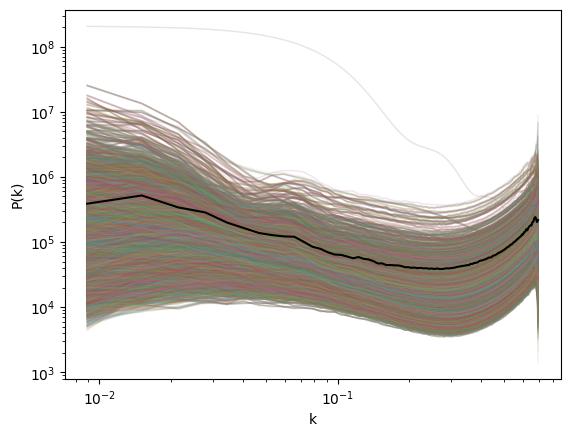

In [23]:
l = 10

f, ax = plt.subplots()
cmap = mpl.cm.get_cmap('viridis')
Om = cosmotrain[:,0]
for k, Pk, cosmo in zip(ktrain, Pktrain[...,0], Om):
    omnorm = (Om-Om.min())/(Om.max()-Om.min())
    ax.loglog(k, Pk, lw=1, alpha=0.1)
ax.loglog(ktest[l], Pktest[l,...,0], 'k')
ax.set(xlabel='k', ylabel='P(k)')

### Train

In [38]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    embedding = FCN(n_hidden=[64, 32, 16], act_fn='ReLU')

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(
            model='maf', hidden_features=50, num_transforms=5,
            embedding_net=embedding),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 1e-3
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

In [39]:
# train at different resolutions
kmaxs = [0.2]  # [0.1, 0.2, 0.4, 0.6]

# impute with mean
def impute(arr):
    # Compute the mean of each row, ignoring nan values
    col_mean = np.nanmean(arr, axis=1)
    
    # Find the indices where values are nan
    inds = np.where(np.isnan(arr))
    
    # Replace nan values with the mean of the respective column
    arr[inds] = np.take(col_mean, inds[0])
    return arr

In [40]:
cosmotrain

array([[ 0.3271    ,  0.06875   ,  0.6313    , ..., 13.27      ,
        14.08      ,  0.76      ],
       [ 0.3271    ,  0.06875   ,  0.6313    , ..., 13.00022875,
        13.60466515,  0.22013384],
       [ 0.3271    ,  0.06875   ,  0.6313    , ..., 14.09932496,
        13.87064479,  0.6305517 ],
       ...,
       [ 0.1051    ,  0.06743   ,  0.6715    , ..., 14.30958025,
        14.41952373,  1.27056942],
       [ 0.1611    ,  0.03709   ,  0.8161    , ..., 13.7998094 ,
        14.6883052 ,  0.69576353],
       [ 0.1611    ,  0.03709   ,  0.8161    , ..., 14.18884029,
        13.85661737,  1.14621103]])

In [41]:
posteriors, summaries = {}, {}
for kmax in kmaxs:
    print(f'Training for kmax={kmax}')

    # focus on the monopole
    x = Pktrain[:, :, 0]

    # cut on k
    mask = ktrain[0] < kmax
    x = x[:, mask]
    theta = cosmotrain

    # log
    x = np.log10(x)

    # # impute
    # x = impute(x)

    # train
    _p, _s = run_inference(x, theta)
    posteriors[kmax] = _p
    summaries[kmax] = _s


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.2


369 epochs [13:11,  2.14s/ epochs, loss=-17.6, loss_val=-17.2]
INFO:root:It took 791.5525405406952 seconds to train models.


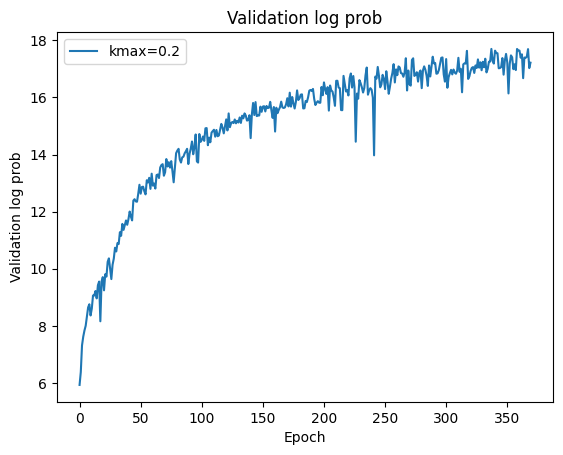

In [42]:
# plot loss functions
f, ax = plt.subplots()
for kmax in kmaxs:
    ax.plot(summaries[kmax][0]['validation_log_probs'], label=f'kmax={kmax}')
ax.set(xlabel='Epoch', ylabel='Validation log prob', title='Validation log prob')
ax.legend()

In [36]:
summaries

{}

### Plot

In [43]:
kmax = 0.2
_p = posteriors[kmax]
xobs = Pktest[:, :, 0]
mask = ktest[0] < kmax
xobs = xobs[:, mask]
xobs = np.log10(xobs)
xobs = impute(xobs)
i = 10
xobs[i], cosmotest[i]

(array([5.58799784, 5.7141756 , 5.53131059, 5.45401363, 5.29832063,
        5.21362783, 5.13833243, 5.10600291, 5.08639531, 5.08069562,
        5.00412331, 4.92831834, 4.89529679, 4.84286144, 4.80761931,
        4.80192268, 4.77721711, 4.75008136, 4.76878941, 4.74142798,
        4.73198617, 4.70678474, 4.67122246, 4.67172226, 4.64591035,
        4.64596499, 4.64148989, 4.64013149, 4.6314247 , 4.61351042,
        4.61285933]),
 array([ 0.1821 ,  0.04809,  0.5865 ,  0.9565 ,  0.8101 , 13.03   ,
         0.38   , 13.27   , 14.08   ,  0.76   ]))

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1319it [00:00, 9594.54it/s]             


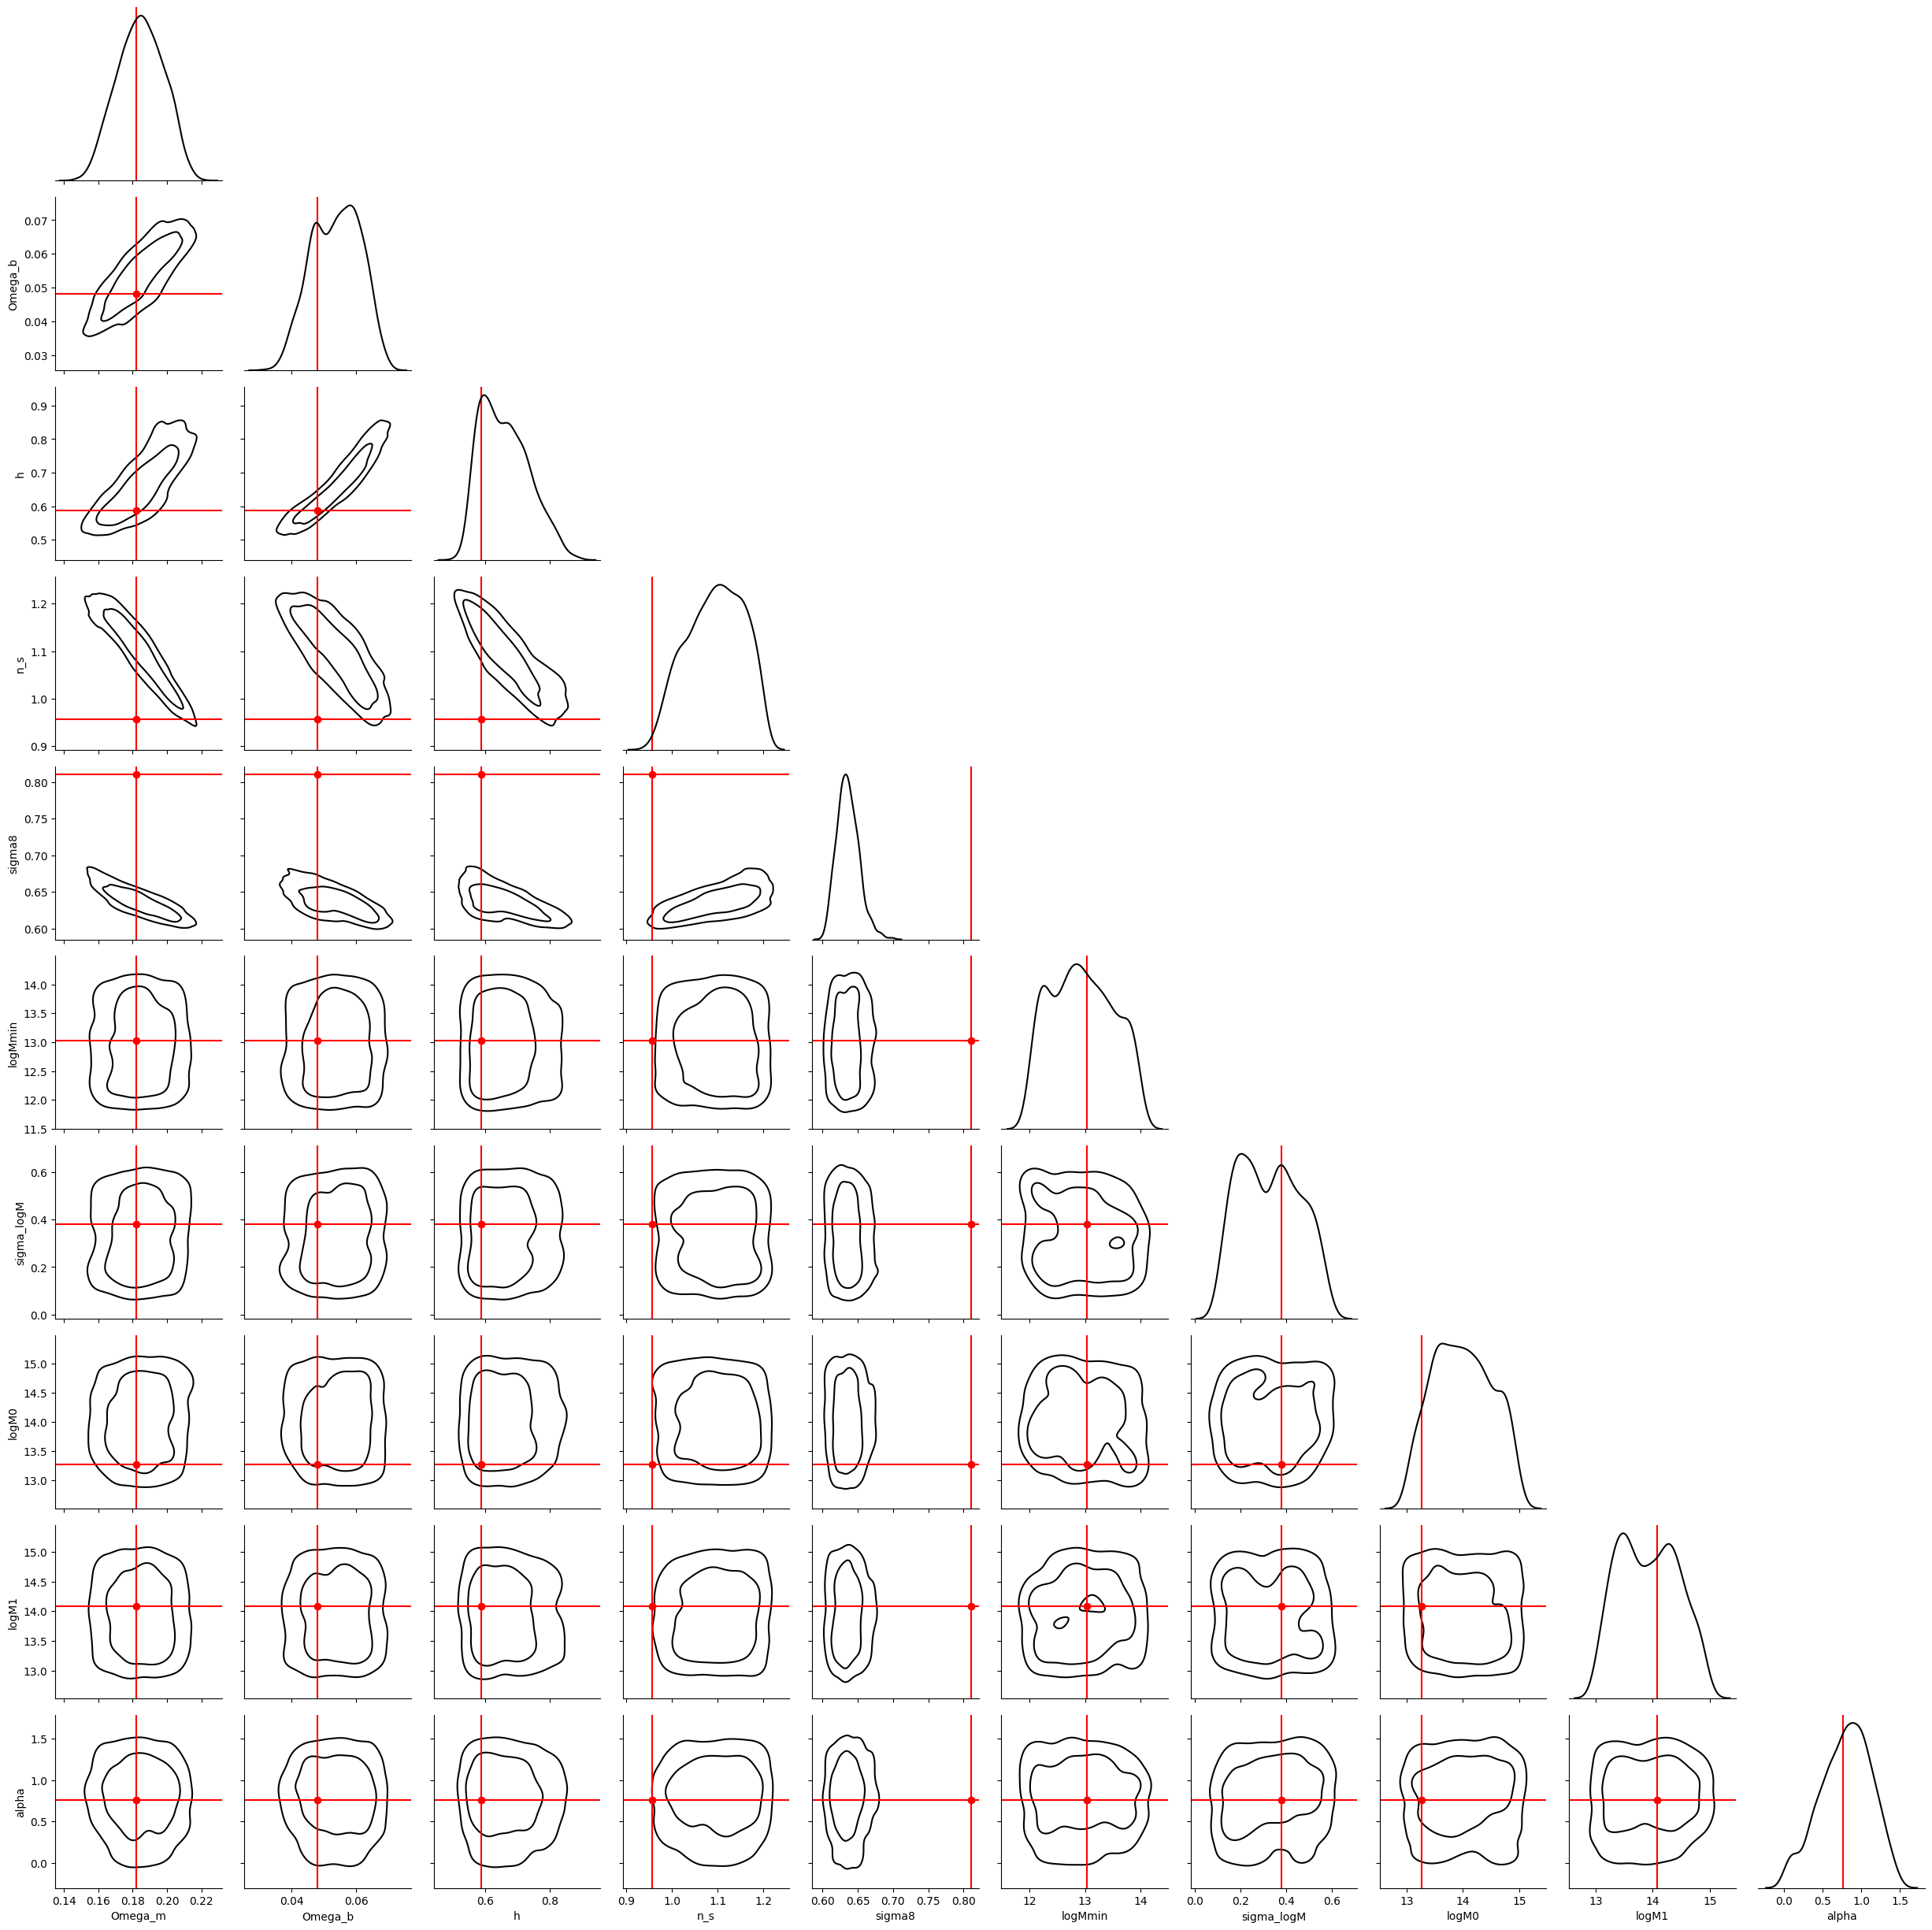

In [44]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8',
            'logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha']
)
fig = metric(
    posterior=_p,
    x_obs = xobs[10], theta_fid = cosmotest[10],
    grid=None,
    name=f'kmax={kmax}'
)

  7%|▋         | 14/200 [00:01<00:21,  8.83it/s]/home/mattho/git/ltu-ili/ili/utils/ndes_pt.py:174: UserWarning: Direct sampling took too long. The posterior is poorly constrained within the prior support. Consider using emcee sampling or using a larger prior support. Returning prior samples.
  warnings.warn(
100%|██████████| 200/200 [00:40<00:00,  4.92it/s]
INFO:root:Mean logprob: -4.9203e+03Median logprob: -3.4301e+03
100%|██████████| 100/100 [00:01<00:00, 50.43it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


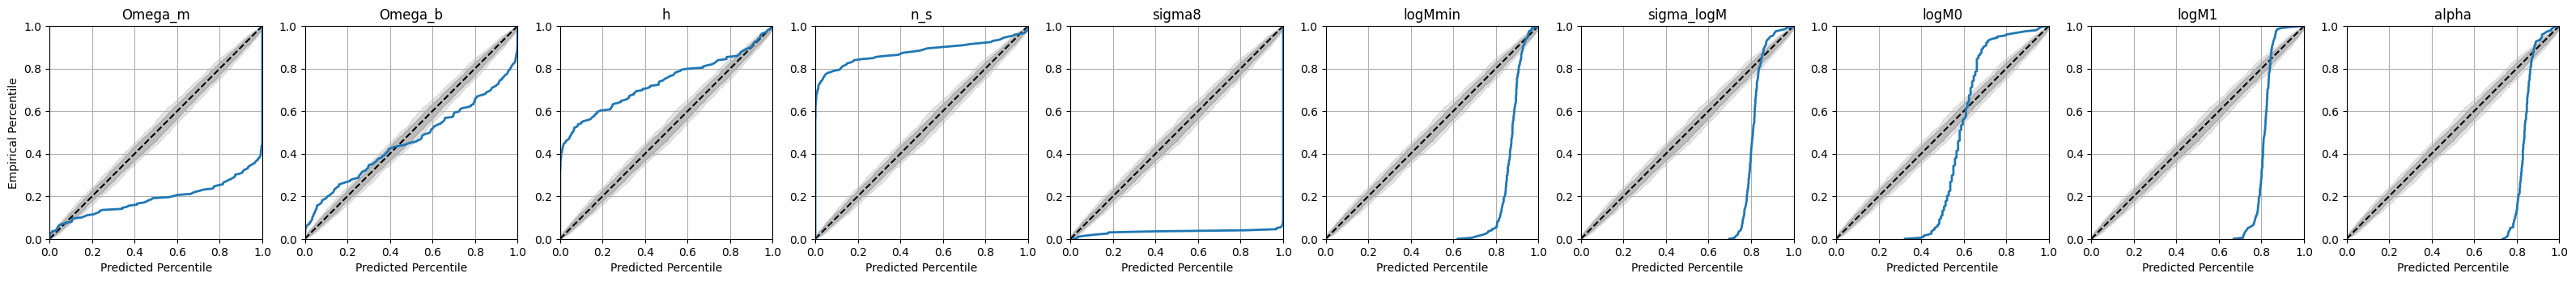

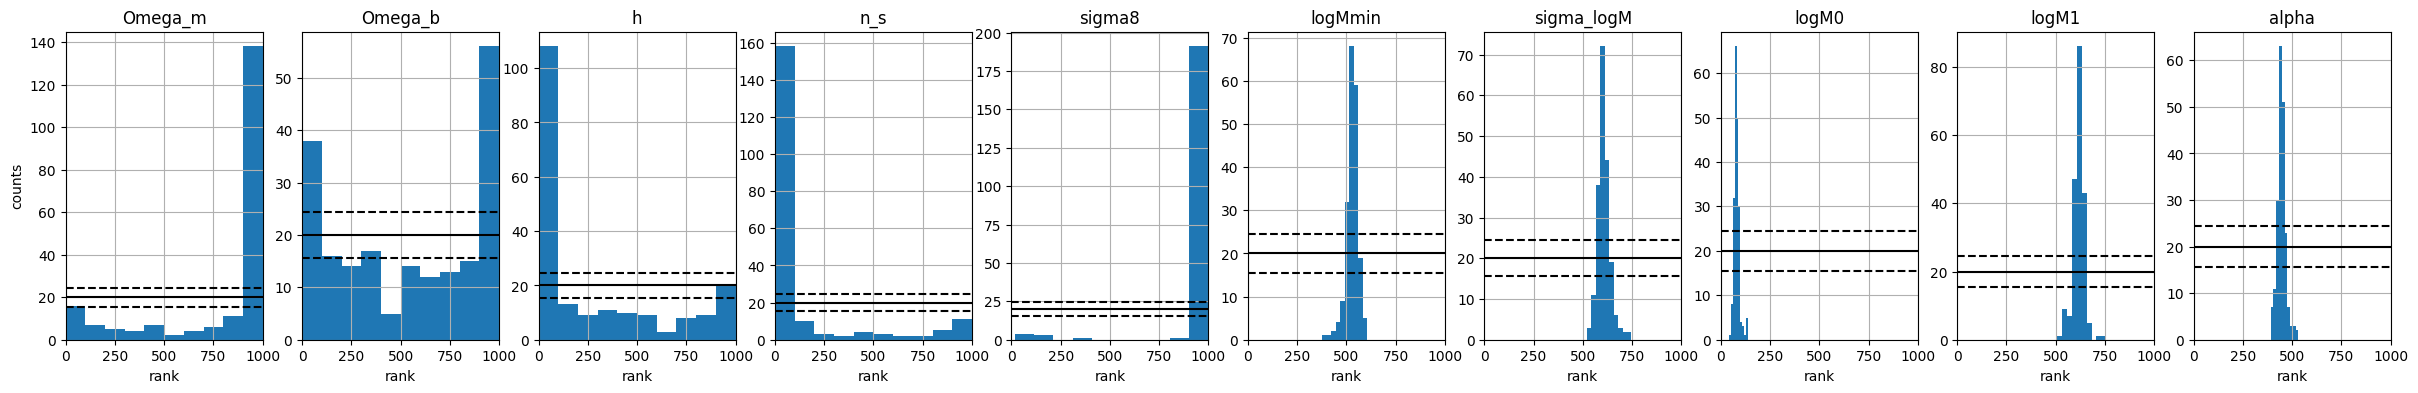

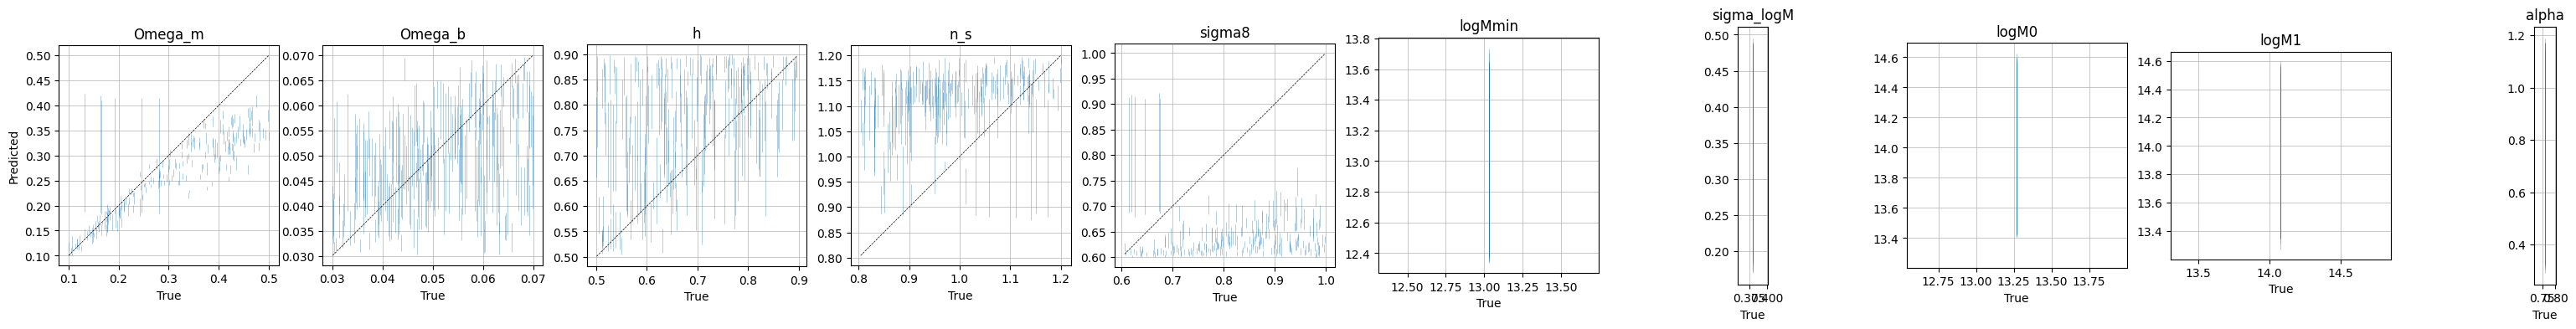

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


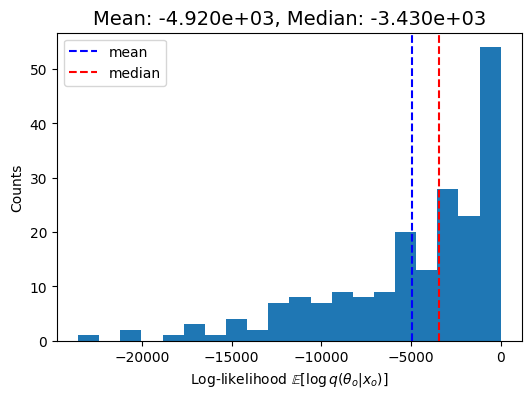

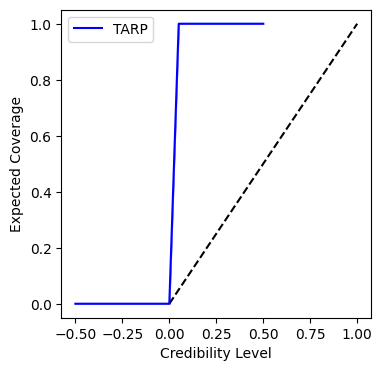

In [45]:
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8',
            'logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)
metric(posterior=_p, x=xobs, theta=cosmotest);

## Scratch

### Compare CHARM across cosmologies

In [11]:
# charm_path = '/automnt/data80/mattho/cmass-ili/quijotelike/fastpm/L1000-N128'
# quijote_path = '/automnt/data80/mattho/cmass-ili/quijote/nbody/L1000-N128'
charm_path = '/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128'
quijote_path = '/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/L1000-N128'

cPks = []
qPks = []
for lhid in tqdm(range(2000)):
    lhid = str(lhid)
    ck, cPk, ccosmo = get_halo_Pk(join(charm_path, lhid))
    qk, qPk, qcosmo = get_halo_Pk(join(quijote_path, lhid))
    cPks.append(cPk)
    qPks.append(qPk)
cPks, qPks = map(np.stack, [cPks, qPks])

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:40<00:00, 49.92it/s]


(0.5, 1.5)

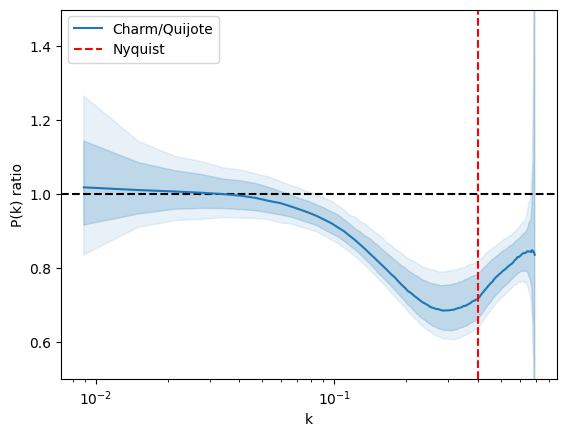

In [12]:
x1 = cPks[...,0]
x2 = qPks[...,0]
y = np.median(x1/x2, axis=0)
yerr = np.percentile(x1/x2, [5, 16, 84, 95], axis=0)
nyq = 2*np.pi/1000 * (128/2)
f, ax = plt.subplots()
ax.semilogx()
ax.axhline(1, c='k', ls='--')
ax.plot(ck, y, label='Charm/Quijote', c='C0')
ax.fill_between(ck, yerr[0], yerr[3], alpha=0.1, color='C0')
ax.fill_between(ck, yerr[1], yerr[2], alpha=0.2, color='C0')
ax.axvline(nyq, c='r', ls='--', label='Nyquist')
ax.legend()
ax.set(xlabel='k', ylabel='P(k) ratio')
ax.set_ylim(0.5,1.5)